In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import torch
from datasets import load_from_disk
from transformers import AutoTokenizer

import os
import itertools
import json
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
# work around insane huggingface requirements
from datasets.utils.logging import set_verbosity_error
set_verbosity_error()

In [4]:
# from spotlight.datasets import *
from torch_spotlight.utils import *
from torch_spotlight.plot_utils import *

setupPlots()

In [5]:
data_dir = '/arc/project/st-kevinlb-1/gregdeon/spotlight/datasets'
model_dir = '/arc/project/st-kevinlb-1/gregdeon/spotlight/models'
os.environ['TRANSFORMERS_CACHE'] = '/scratch/st-kevinlb-1/willib/hf_cache'
os.environ['HF_DATASETS_CACHE'] = '/scratch/st-kevinlb-1/willib/hf_cache'
os.environ['HF_HOME'] = '/scratch/st-kevinlb-1/willib/hf_cache'
amazon_dir = os.path.join(data_dir, 'amazon')
amazon_model_path = os.path.join(model_dir, 'amazon')
squad_dir = os.path.join(data_dir, 'squad')
squad_model_path = os.path.join(model_dir, 'squad')

# Amazon reviews

## Dataset + tokenizer

In [6]:
dataset = load_from_disk(amazon_dir)['test']

In [8]:
dataset[123]

{'content': 'I do love "Charlie Brown\'s Christmas", a joy for the entire family, young and old. A Christmas play is being directed by Charlie Brown, and everyone is complaining. Charlie is sad because he doesn\'t know the true spirit of Christmas, and his friend tells him the spirit of Christmas. The play was never finished though.I like this toon because "Charlie Brown\'s Christmas" had the guts to tell about Gabriel telling the shepherds about the Good news that Baby Jesus was born in the manger. I would recommend this to all!',
 'label': 1,
 'title': 'I ought to slug those R movie loving critics! "They don\'t know entertainment" as Krusty would say'}

In [9]:
num_examples = 20000
amazon_labels = [dataset[i]['label'] for i in range(num_examples)]

In [10]:
tokenizer = AutoTokenizer.from_pretrained(
    "distilbert-base-uncased-finetuned-sst-2-english", 
    do_lower_case=True, 
    do_basic_tokenize=True,
    local_files_only=True,
    cache_dir=amazon_model_path
)

In [11]:
unique_tokens = []
for i in tqdm(range(num_examples)):
    tokenized = tokenizer(dataset[i]['content'], padding=True, return_tensors='pt')
    unique_tokens.append(torch.unique(tokenized['input_ids']))

100%|██████████| 20000/20000 [00:10<00:00, 1919.84it/s]


## Model outputs

In [12]:
inf_results = loadResults(
    os.path.join(os.getcwd(),'inference_results/amazon_train_sst_20k_new.pkl'),
)
losses = inf_results.losses
outputs = inf_results.outputs

In [13]:
loss_idx = losses.argsort().tolist()[::-1]
for idx in loss_idx[:10]:
    example = dataset[idx]
    display(example['content'])
    display(example['label'])
    display(losses[idx])
    print()

"This production is so awesome we can't stop watching it over and over. It is one of the finest vocal performances I have ever seen."

0

tensor(9.0710)

'Very nice peridot necklace. I bought the 3-piece set for a birthday gift, and I was proud to give it as a gift.'

0

tensor(8.9754)

'love the movie. made me cry. I was expecting the original movie but it still is a wonderful story to watch'

0

tensor(8.9253)

'This was my first encounter with the magical realism style and I love it! The Buendia family is quite possibly the most intriguing I have encountered in any book. A must read.'

0

tensor(8.9095)

'This one gift I could give my grown daughter. I read this book over and over to her as a child. It was in wonderful condition!'

0

tensor(8.8914)

"I watched the movie on Cartoon Network about two years ago. It's an excellent movie, I tell you. It's facinating!!! ^_^I loved the characters and their personalities. I seriously loved the art designs animation. It brings out the true life of the movie. In my opinion, this DVD is great! You should get this DVD and soon. It ROCKS! ^_^!"

0

tensor(8.8772)

'Like it. Love it. Live in Paris will always be in my top 5. She is a star with this incredible band. Some of her originals are too melancholy for me, but she is truly unique in her talents. Who else can compose, sing and play jazz piano like that? Who was the girl?'

0

tensor(8.7896)

'This is Hawaiian music done very well. Darnall is a master arranger and player of string instruments. Most songs could be background music. However! Over the Rainbow is pure genius. Unforgettable. I would use the word, haunting. I think Judy Garland would approve.'

0

tensor(8.7384)

'Jerry Garcia was a stone cold genius. The Grateful Dead was his backup band. Bob Weir\'s solo work is easily as good as the solo work of Bill Wyman, Keith Moon, Dave Davies, and Clarence Clemmons. From a 40 year career this is the "best" they could come up with?'

0

tensor(8.7288)

'The background music is not clear and the CD was a waste of money. One star is too high.'

1

tensor(8.6523)

## Spotlights

In [14]:
spotlights = {}
for count in np.arange(1, 6):
    spotlights[count] = loadResults(f'spotlight_results/amazon_train_sst_0.05_{count}.pkl')
    


In [16]:
# Example of high-weight reviews
spotlight = spotlights[1]
weight_idx = spotlight['weights'].argsort().tolist()[::-1]
for idx in weight_idx[:50]:
    example = dataset[idx]
    display(idx)
    display(example['content'])
    display(example['label'])
    display(losses[idx])
    display(outputs[idx])
    print()

12480

'So I ordered this with tahitian cardio, which is AMAZING. So after doing that and the tahitian hip hop (they come together) I decided to try the Cardio Hula. When i took it out of its schrink wrapped case, it definately did look a little funny. I put it in my Boyfriends XBOX 360 and it didnt recognize it as a disk. I tried it in our dvd player, and it still didnt recognise it as a dvd. I looked at the surface, to see if there was any scratches, and to my confusion it was blue, like a DVD-R. I flipped it over and looked more closely at the top and noticed that whoever printed the label needed their printer heads cleaned. I ordered if FROM amazon, I even got the supersaver shipping, which brought my bootleg DVD in record time. I only can play it on my laptop which has a TINY screen.Thanks Amazon, thanks'

0

tensor(0.0346)

tensor(0.0340)

4212

"This is LOTR light; Well written, but not nearly to the fullest extent of the literary powers Tolkein reached later with LOTR. The story too, is more for younger folks. It should however be read before LOTR because it provides necessary background. It's a quick read too - 1 day."

1

tensor(3.2731)

tensor(0.0379)

1808

"It is my girls first year in ballet so I just wanted an inexpensive bag. If you want a really nice bag don't waste your money here. The entire bag is made of urethane and has a cheap feel. The biggest positives are the cute graphics and the straps work well."

0

tensor(0.0412)

tensor(0.0404)

3924

"Love the quality of the movieI have a high def wide screen tvwent to the ROOT MENUthe audio had an echo like the sound in a movie theatreAdjusted the audio from Theatre to Living Room and that corrected the musicBUT I still got the echo on my tv for the talkingI played it on my computer--and worked very wellI will have to deal with my tv later! It readjusted the whole tv system.Ah the good old days before HD and all that jazz!There must be a sound adjustment I haven't adjusted yet."

1

tensor(3.5575)

tensor(0.0285)

9966

"This book is great and all, the only problem is, you have to make sure you know the words in shorthand already. This book doesn't waste any time and goes straight to the transcription, but that may not be so good for new users. Other than that, this book is great and really goes indepth with the way to transcipt your shorthand notes."

1

tensor(3.0550)

tensor(0.0471)

19215

'Do NOT waste your money on this! I am 28 years old and have always had oily/problem skin. The benzoyl peroxide in the face wash and "day cream" burn and sting when you apply. Also you can\'t realistically apply the day cream during the day as it leaves a messy white residue on your face. My face never felt clean using this product and I continued to break out. I would use the spot treatment on existing treatments and I would have to say that is the only semi good product they offer: it dries up an existing pimple faster as opposed to using nothing at all. If you expect this to stop your acne it won\'t, benzoyle peroxide is awful for yous skin and known to cause thin skin and premature aging. As a side note I have started using Lerosett, an organic clay mask/face wash skin care line and let me tell you it is amazing! I have cystic acne and it works. If you are looking for something on the cheaper side try Aztec healing clay, does wonders. :)'

0

tensor(0.0444)

tensor(0.0434)

15255

"Very nice air hose. I store all 100 ft of it on an electrical cord spool, fits perfect. The re-enforced ends help keep it from kinking, but will still kink if not careful.Can't beat the price either."

1

tensor(3.1833)

tensor(0.0414)

9304

'I still think my kata dr 461 is better because of the added chest support strap and wider slimmer look but this will beat any shoulder bag. For long walks be it in the city or at a trail I am always looking for a small backpack to fill my needs. This little fellow was smaller than I thought but still I take it and put it to use for my backup dslr when I go out and about.'

1

tensor(3.4329)

tensor(0.0323)

9137

'this is one of the few items I have ever has to return. The fan stopped working just after two days. I did get a prompt refund from amazon.'

0

tensor(0.0262)

tensor(0.0259)

10543

"I'm sure this is a great product, but my speakers are 9 foot away, and i massively can't be bothered to go and move them. I left the cable on the kitchen table.Also, the packaging has some very racial things stated in it."

0

tensor(0.0518)

tensor(0.0505)

7679

"Great Backpack! Love the color! The only thing, is that it gets dirty easily. I got a pen mark on the pocket, and I'm not sure how to remove it :("

1

tensor(2.8205)

tensor(0.0596)

3450

"I'm using this on a Win98SE PC to connect to an Apple AirPort Base Station. It sees the base station fine, but when the Belkin is touching the base station it transmits at 70% signal strength. My PowerBook can see the base station at 100% one floor up, 80% on the second floor up.Belkin software was easy to use and configure. Maybe my HP Pavilion causes a lot of RF interference? Unknown, but I'd try a Linksys or Hawking over the Blekin. Don't be swayed by the price."

0

tensor(0.0434)

tensor(0.0424)

14374

"Jake Grafton has to teach marines what it's like to be on an aircraft carrier. Landing and taking off on a slipery deck, learning all the parts to a carrier and how to put up with Flap LeBeau. This book you can't put down, I couldn't."

1

tensor(3.3566)

tensor(0.0349)

11713

'Mas Amedda was always one of the more interesting aliens in the prequels. This figure gets pretty high marks. The only thing I would like to see in a future update is a soft goods outer cloak. The hard plastic works well enough but limits articulation. Also, the soft goods would probably just look even more regal.'

1

tensor(3.2424)

tensor(0.0391)

14406

'this album isnt good like megadeth albums but its not so bad dave is great rythem ... guitar player but you dont see in this album guitar riffs like in megdeth rust in peace- countdown - and youatnsia if your megadet hfun buy this if your not mega fun dont buy this /.'

1

tensor(3.3459)

tensor(0.0352)

15683

"Love the functionality - being able to separate for different uses esp. meat and that they flex to enable direct frop into the pan. But mine came off color (sorta transparent) at the corners (and this wasn't a deisgn feaure since there was no pattern in all the four sheets) but still good value - not worth exchanging so I kept them. I guess mine look unique."

1

tensor(3.2593)

tensor(0.0384)

7109

'Great value for the price..... very comfortable and easy to use. The one thing I find which causes some discomfort is the foot cushioning mechanism. Being that you are actually hanging by your feet in full vertical, I feel the cushioning should have been designed in such a way in order to prevent any possibility of pain..... I do experience pain in the back of my ankles once hanging for over a minute, or after doing crunches. I\'m 5\'5" tall and weight 112 lbs., so it is not due to excessive weight. Otherwise the product is a great deal.'

1

tensor(3.5391)

tensor(0.0290)

8518

'I have had a shower head like this in the past so when it came time to replace the old handheld one we had, I went looking for this type. I couldn\'t find it locally so was pleased when Amazon had it. Easy installation (no thread tape needed, uses a rubber seal to tighten against) and you can aim the water pretty much anywhere once installed. I am 6\' 4" and this is the only shower head that I have been able to actually get under. The rest of my family is very pleased with it too so I would recommend buying this shower head 100%.'

1

tensor(3.6631)

tensor(0.0257)

18339

'If you own a Turbo Scratcher you will need to purchase replacement pads for it. Cats love these pads to sharpen their claws, but they will rip them up pretty quickly. The only downside to them is they are quite expensive for something that is nothing more than cardboard. Amazon has the best price for these replacement pads, and you will want to buy them in quantity.When your pad gets torn up you can flip it over to get additional usage out of it. Cats will enjoy them even more if you sprinkle catnip on them - our cats will roll around on top of them and lay on them.'

1

tensor(3.1822)

tensor(0.0415)

2605

'I was having trouble finding a copy of this classic movie anywhere. I was eccited to see a copy on DVD Unfortunatley the word "COPY" is correct. It was a copy. The quality is good and the Menu looks good but the disc was definetly a copy. The case was also a copy. I am glad to have this in my collection nonetheless but was upset it was not original.'

0

tensor(0.0308)

tensor(0.0303)

15353

'This is a great idea. I don\'t have to worry about stepping on my cat when I walk around the house with the lights off. Only problem is my cat has a med size neck (from other custom collars I\'ve ordered)and this collar is very large. I had to move the black plastic buckle to the middle of the "plastic glow band" in order to fit my cat. The glow part is plastic and stiff, so the buckle doesn\'t easily adjust to fit smaller cats.'

1

tensor(3.1100)

tensor(0.0446)

7896

'these head phones are great for truck drivers, the battery life is on ly about 8 hours other than that there perfect'

1

tensor(3.0363)

tensor(0.0480)

2105

"pro's :great fun, portable.con's: hard to read LED except in darkness ,no off button.As soon as I got this toy I started playing it.but then ,I found out that in bright light I could not see the LED so I went in some shade.Now thats just fine except theres no shade indoors!so I found a dull light and used it.But then I brushed the yesbutton and no button would turn it off so I had to play it though.But overall if you have a dull reading light and you are patient, buy this product."

1

tensor(3.4328)

tensor(0.0323)

6898

'I love the other films Peter Jackson has made. The best is Heavenly Creatures, if you have not seen this movie your missing out! I thought this movie was overly dramatic and to long. Had many unbeliveable moments and was so far fetched! The only cool thing about it was the natives, they were freaky.'

0

tensor(0.0314)

tensor(0.0309)

14849

'The Allen wrenches are well made and come in an excellent assortment of sizes. The balldriver tip and long shaft make these wrenches particularly suited for hard-to-reach areas.I have not used the Torx wrenches, as I already have a set. The handle that the torx wrenches fold into is plastic and feels a little flimsy, but this is a "bonus set" and didn\'t influence my purchase decision.'

1

tensor(2.9953)

tensor(0.0500)

17507

"There r 2 good songs on here. If you wanna find a good album by Vizzan Halen, get the third!!!! It has the singer from one of the GRIZZEATEST BANDS EVER: EXTREME! David & Sammy are DONE! You're 15 mins of fizzame are OVER, dudes! Just download the 2 good songs!"

0

tensor(0.0314)

tensor(0.0309)

318

"I try everything new, hoping to find something that will show me some results right away and give me back the glow in my skin that seems to wither away as time passes (and I'm only 36!) --Anyway, when I read about rice bran, I thought why not - this brand contains a lot of rice bran - it's like the 2nd ingredient in everything after water, and there is nothing else in it I couldn't pronounce. The stuff smells great, and goes on non-greasy, especially the face cream it's like my face is so thirsty for it that it just sucks it all in. The TrueRenu store gives you cute little pahmplets with details on all the ingredients, and insturctions (the packages are written in Japanese so you need to read their instructions) - and I even got a free gift of green tea - yum!"

1

tensor(3.1198)

tensor(0.0442)

76

"I have been looking for something to hold in my stomach that wasn't elastic based. Found this item and have to say I am pretty pleased. The hooks do take a while, but once they are all done, the waist cincher does what it says it will do. The only negative thing is what a lot of the other reviews complain about. It does tend to cause back fat to appear more prominent by your underarms. So I can't wear this with a top that is clingy. Can only wear with looser fitting shirts. Oh well, nothing is perfect."

1

tensor(3.2000)

tensor(0.0408)

8183

'The first time I put this CD into the Discman, I was feelin it. The album was pretty hot. Than I heard it again. The beats are tight, but Bone sounds like Popeye. They gotta slow down the flow.'

0

tensor(0.0475)

tensor(0.0464)

14913

'I purchased two boxes of nails and was afraid to get them all busted up, after I read the other reviews. But I bet there is maybe a total of two sticks worth of pieces. I mean a couple off the ends of sticks, to total 2 complete sticks. I would say there 99.8 % useable. Great price and free freight.'

1

tensor(3.7128)

tensor(0.0244)

2340

'This book is an excellent story. Lots of California history..or better..Alta California as it was known in the era.BEWARE OF THE PHYSICAL BOOK !!!!! It is about 10"x11"...printing of the story is VERY!!!! pale.I will keep this....but have ordered an older, normal paperback version...similar to the one I left accidentally at the San Diego airport.Terrible size and print itself. Find another book of Ramona, by Helen Hunt Jackson....and be ready to want to go to Old Town San Diego.Michaelene Gon.'

0

tensor(0.0353)

tensor(0.0347)

17557

"I chose that rating cause I truly feel that they could've done a better job showing hendrix's visionas an artist of that era. They never delved into his personal feelings about his own music and they also never mentioned how he felt trapped between his Contracts with ppx industries all of his legal problems with his record companies. And the music that wasn't hendrix was terrible."

0

tensor(0.0292)

tensor(0.0288)

6417

"These are great songs but I agree with earlier reviewers. This is not a greatest hits album. Why so few tracks over 2 cds? Roll With It, Whatever, Stand By Me, All Around the World, Hindu Times, Stop Crying Your Heart Out, Little By Little, It's Good to Be Free and Round Are Way are all BIG omissions. Especially Little By Little."

1

tensor(3.3776)

tensor(0.0341)

6816

"If you are one of those consumers (as I am) that will purchase products because of aesthetics, then this product is for you/your dog. We have the large version and it is almost too big for our black lab--it holds a lot of food. The bowl has a nice weight to it and non-skid feet. Please note that our turquoise bowl faded, and although this bowl is dishwasher-safe we washed it by hand. The underside of the bowl stayed bright turquoise, but the exposed side faded quite a bit in a few months. The polymer material the bowl is constructed of is heavy and sturdy, however, it is also very rigid and I discovered that if you drop the bowl it breaks into many sharp pieces. It's a great design and I would recommend purchasing it if you like the design, but expect the color to fade and handle carefully."

1

tensor(2.8926)

tensor(0.0554)

16878

'this stater is actually 20 percent stronger and last longer ive had it in my bike over a year now and as soon as i put it in i felt it had more power im bout to buy an extra one and sell this for more'

1

tensor(3.2662)

tensor(0.0381)

7479

'This movie is just too good for words. It gives you as many laughs as the red green show. The slapstick shenanighans keep comming as the laughs keep rolling. I once laughed so hard i fell asleep and woke up and turned the movie off. One liners, Obesity, Gags, Puns, ensue. Go and rent this now along with once bitten.'

1

tensor(3.3703)

tensor(0.0344)

12844

'I now own 3 of these Hunter made holsters. The 1090-50 crossdraw "only" fits Colt clones with barrels up to 7 1/2". The 1090-40 "two way, crossdraw or strong side use," fits Colt clones with barrels up to 6". I like a crossdraw that hangs more horizontal than vertical, the 1090-40 does that more so than the 1090-50. Also, the 1090-50 has a closed end while the 1090-40 has an open end. Very basic unlined but useful, to me, holsters.'

1

tensor(3.5103)

tensor(0.0299)

11324

'The book is fine for beginners in the conservation genetics.So the price, I think that is expensive, because the book is just only an introductionto conservation genetics.'

0

tensor(0.0537)

tensor(0.0523)

2731

'I have moderatly curly hair and have never known how to style it. I am uncoordinated with flat irons and round brushes with hair dryers. This thing is awsome. I can easily style my hair straight and not feel like I need an extra hand. It is adjustable depending how curly your hair is. It is easily packable for traveling. Apply straightning product, if desired, after you wash, then style when your hair is about two thirds dry, or if you wash your hair at night, just dampen it a little in the AM and style.'

1

tensor(3.2149)

tensor(0.0402)

14754

'I think the material in this audio book is amazing.I have a hard time getting through it because of the actor chosen to read the text.His voice and affectations are beyond annoying.I wish careful consideration would be given when it comes to choosing who is to read for the audio book!'

0

tensor(0.0441)

tensor(0.0431)

5832

'I really like the product, its way smaller that I thought, 2 reason i had to send it back, 1. dead pixel, 2. had to reset 3 times in one hour. i dont know wat the heck is wrong with it. it doesnt support kingstore secure digital card, (4gb), otherwise the lcd is cristal clear, has wifi internet which is preety amazing, fast, i didnt get to see everything yet cuz i shiped it back the same day i got it, hope the one i am getting now comes with no diffects.'

1

tensor(3.5558)

tensor(0.0286)

15893

"Well, my review is a short one...I am a real fanatic of all the novels, I read the six of them 5 times, both in French and in English...BUT this movie is way too weird, most of the actors are week, it's like dune in Twin Peaks...Well, no thanks, the true fans will understand the incompatibility !!!!"

0

tensor(0.0308)

tensor(0.0304)

819

"this game is hard and I still havn't beaten it, and I have had it for two mothes. I reconmend for only skilled players play.DELTA 904thanks for youre time and patience"

1

tensor(3.1931)

tensor(0.0410)

5843

"Well you don't have to be a history buff to get the gags in this movie. Both lead actresses have that ditzy, aloof girl next door routine done pat and this along with the situations they accidently find themselves in makes for one heck of a re-watchable movie. I usually love DVD's that have enough content to last 10 or more viewings and this definately one of them. There are plenty of jokes or play on the word ' Dick ' in this movie and that alone is good enough to last for multiple viewings. I'm not a history buff, but you don't have to be to get how ' Walnut Leaves ' could have re-written the history books...There's to much to this movie to explain, just buy its money well spent."

1

tensor(3.4441)

tensor(0.0319)

18363

"We are about 7 or 8 months into this water heater and have had it. We have fiddled with the temperature control enough. This weekend I am going to buy a old reliable conventional unit. We haven't had some of the horrendous problems others have reported. I think if I had, I wouldn't have put up with it for 8 minutes, let alone 8 months. But honestly, getting hot water shouldn't require all the gymnastics that are required to keep this thing adjusted - managing the flow rate, changing the temperature setting according to the seasons, resetting the little breakers when they trip - honestly. [...] If you like to tinker with the water heater all the time then maybe this is the unit for you. Especially if you like occassional cold showers in January and racing through the house bare-naked trying to see if the little red light is on. No thanks!"

0

tensor(0.0267)

tensor(0.0264)

5267

"I have used this aquarium in my daughter's crib since she was two months old. She is now 10 months and still loves it! More importantly, when we lay her down and press it on, the music signals to her that it is time for bed. She willingly rolls over to look at it and eventually falls asleep. She used to press it on herself in the middle of the night to go back to sleep(when her crib was lower and the aquarium was more accessible). I would reccommend this soothing toy to anyone and suggest to start using it early on. The only modifications I would make would be a remote control for parents to turn it on without entering the room(it only goes for 7 minutes) and maybe longer straps so that when the crib is lowered the baby can still reach it."

1

tensor(3.3035)

tensor(0.0368)

10615

"Really tried to like this book. Premise was grand; story bobbed and weaved; conclusion was flimsy. Discursive scientific literalizations distract & disorient. Crichton breaks the rule to never stanch the flow. I dislike the quartet of scientists who investigate the outbreak; they don't come across to the reader as likeable."

0

tensor(0.0302)

tensor(0.0297)

8352

"Yes folks, it's true. Bobby taught James everything he knows. Not to detract from the Godfather himself, but Bobby is just so underrated by most who think they know something about soul music. One must take into consideration that this is a greatest hits compilation and as such has some duds in it as filler. But when you put that first track on and hear that first guitar pickin intro and then hear James back in the sound booth just shouting to get out, it's because he knows Bobby's got soul."

1

tensor(3.1275)

tensor(0.0438)

5836

"I am restricted to a wheelchair, and so must rely on grabbers,to assist me when reaching for things in higher areas or across wide spacess. I already had one of the ergonomically 18' grabbers in this style and really liked the light wt. and dexterity it allowed me, over many of the other styles. So, I was very disappointd when after the THIRD time I used it, I heard a click and part of the internal workings actually came through the handle, Now, it just takes up space while I try to see if I can get my money back. Needless to say, I am aggeivated and dissapointd. DONT BUY THIS PRODUCT."

0

tensor(0.0241)

tensor(0.0238)

16820

'Red Rodney\'s "1957" is a great album but it is the exact same material as is on the Savoy CD "Fiery" (see my review). I mail-ordered this title without realizing this. Don\'t repeat my mistake.'

1

tensor(3.2600)

tensor(0.0384)

In [22]:
def getCommonTokens(weights, smoothing=0.01, print_first=50):
    token_frequencies = defaultdict(float)
    token_frequencies_spotlight = defaultdict(float)

    weights_uniform = np.full_like(weights, 1 / len(weights))

    num_examples = len(weights)
    for i in tqdm(range(num_examples)):
        for token in unique_tokens[i]:
            token_frequencies[token.item()] += weights_uniform[i]
            token_frequencies_spotlight[token.item()] += weights[i]
            
    token_lrs = {k: (smoothing+token_frequencies_spotlight[k]) / (smoothing+token_frequencies[k]) for k in token_frequencies}
    tokens_sorted = list(map(lambda x: x[0], sorted(token_lrs.items(), key=lambda x: x[1])[::-1]))
    for i, (token) in enumerate(tokens_sorted[:print_first]):
        wordcloud_dict[tokenizer.decode(token)] = token_frequencies_spotlight[token]
        print('%15s %.4f %.4f %4.2f' % (tokenizer.decode(token), token_frequencies[token], token_frequencies_spotlight[token], token_lrs[token]))

In [32]:
wordcloud_dict = {}
getCommonTokens(spotlights[2]['weights'], 0.005, 20)
print(wordcloud_dict)

100%|██████████| 20000/20000 [00:03<00:00, 5414.93it/s]

         bigger 0.0035 0.0090 1.65
          super 0.0104 0.0203 1.64
           hang 0.0028 0.0075 1.60
         prefer 0.0057 0.0120 1.58
        killing 0.0028 0.0074 1.58
            job 0.0239 0.0405 1.57
       discover 0.0029 0.0075 1.57
           slip 0.0026 0.0070 1.57
            rev 0.0039 0.0089 1.56
           easy 0.0415 0.0676 1.56
        wearing 0.0035 0.0083 1.56
          ##ves 0.0019 0.0058 1.56
         ##ling 0.0059 0.0119 1.55
             bt 0.0013 0.0048 1.54
           heat 0.0049 0.0103 1.54
           thus 0.0037 0.0084 1.54
           trip 0.0090 0.0165 1.54
            ##x 0.0118 0.0209 1.54
          handy 0.0021 0.0059 1.53
         source 0.0043 0.0092 1.53
{'bigger': 0.009040637821833362, 'super': 0.020319235169222658, 'hang': 0.007536644307705075, 'prefer': 0.012026955929877764, 'killing': 0.007420818905560345, 'job': 0.04050461300650534, 'discover': 0.007484226822065342, 'slip': 0.007011891299408695, 'rev': 0.008914522076781846, 'easy': 0.0675731790

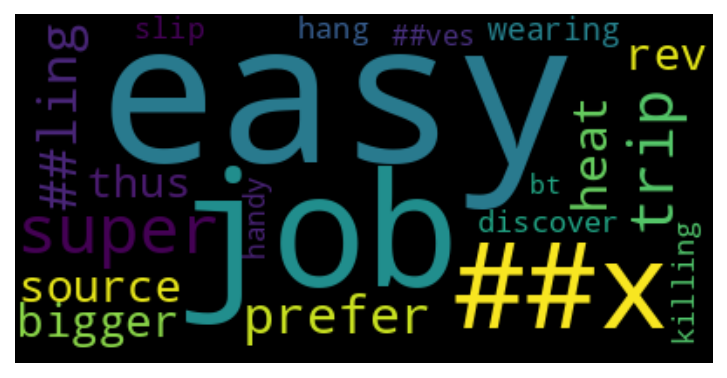

In [33]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=wordcloud_dict)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [21]:
getCommonTokens(spotlights[2][0], 0.005, 20)

100%|██████████| 20000/20000 [00:03<00:00, 6399.25it/s]


         bigger 0.0035 0.0090 1.65
          super 0.0104 0.0203 1.64
           hang 0.0028 0.0075 1.60
         prefer 0.0057 0.0120 1.58
        killing 0.0028 0.0074 1.58
            job 0.0239 0.0405 1.57
       discover 0.0029 0.0075 1.57
           slip 0.0026 0.0070 1.57
            rev 0.0039 0.0089 1.56
           easy 0.0415 0.0676 1.56
        wearing 0.0035 0.0083 1.56
          ##ves 0.0019 0.0058 1.56
         ##ling 0.0059 0.0119 1.55
             bt 0.0013 0.0048 1.54
           heat 0.0049 0.0103 1.54
           thus 0.0037 0.0084 1.54
           trip 0.0090 0.0165 1.54
            ##x 0.0118 0.0209 1.54
          handy 0.0021 0.0059 1.53
         source 0.0043 0.0092 1.53


In [22]:
getCommonTokens(spotlights[3][0], 0.005, 20)

100%|██████████| 20000/20000 [00:03<00:00, 6372.25it/s]

        problem 0.0279 0.0531 1.76
        ##point 0.0113 0.0236 1.76
      returning 0.0048 0.0120 1.73
          ##ssa 0.0082 0.0173 1.69
          ##und 0.0071 0.0153 1.67
              $ 0.0234 0.0420 1.66
         hoping 0.0092 0.0182 1.63
       returned 0.0091 0.0180 1.63
  unfortunately 0.0158 0.0280 1.58
           okay 0.0088 0.0167 1.57
         ##ware 0.0072 0.0142 1.56
            ##0 0.0057 0.0118 1.56
            box 0.0181 0.0310 1.55
         unless 0.0141 0.0244 1.54
          sadly 0.0051 0.0103 1.52
             ok 0.0174 0.0291 1.52
          maybe 0.0297 0.0477 1.52
        however 0.0503 0.0788 1.52
           half 0.0210 0.0344 1.51
           warn 0.0022 0.0060 1.51


In [144]:
loss_weights = (losses > 6.13)
loss_weights = high_loss_weights / high_loss_weights.sum()
getCommonTokens(loss_weights, 0.005, 20)

100%|██████████| 20000/20000 [00:03<00:00, 5456.58it/s]

          ##ven 0.0025 0.0174 2.98
            sen 0.0033 0.0174 2.71
             64 0.0010 0.0099 2.51
         length 0.0052 0.0199 2.42
       outdated 0.0022 0.0124 2.42
         potter 0.0022 0.0124 2.40
         bubble 0.0012 0.0099 2.39
              = 0.0024 0.0124 2.34
            rom 0.0014 0.0099 2.33
        contact 0.0037 0.0149 2.30
 cinematography 0.0026 0.0124 2.29
      adjusting 0.0006 0.0074 2.22
      functions 0.0018 0.0099 2.19
          stock 0.0042 0.0149 2.16
         versus 0.0008 0.0074 2.15
             bu 0.0032 0.0124 2.14
            fix 0.0044 0.0149 2.12
      confirmed 0.0010 0.0074 2.09
           wars 0.0021 0.0099 2.09
          ##nes 0.0010 0.0074 2.07


In [20]:
# word cloud
spotlight = spotlights[1]
weight_idx = spotlight['weights'].argsort().tolist()[::-1]
for idx in weight_idx[:100]:
    example = dataset[idx]
    display(idx)
    display(example['content'])
    display(example['label'])
    display(losses[idx])
    display(outputs[idx])
    print()

12480

'So I ordered this with tahitian cardio, which is AMAZING. So after doing that and the tahitian hip hop (they come together) I decided to try the Cardio Hula. When i took it out of its schrink wrapped case, it definately did look a little funny. I put it in my Boyfriends XBOX 360 and it didnt recognize it as a disk. I tried it in our dvd player, and it still didnt recognise it as a dvd. I looked at the surface, to see if there was any scratches, and to my confusion it was blue, like a DVD-R. I flipped it over and looked more closely at the top and noticed that whoever printed the label needed their printer heads cleaned. I ordered if FROM amazon, I even got the supersaver shipping, which brought my bootleg DVD in record time. I only can play it on my laptop which has a TINY screen.Thanks Amazon, thanks'

0

tensor(0.0346)

tensor(0.0340)

4212

"This is LOTR light; Well written, but not nearly to the fullest extent of the literary powers Tolkein reached later with LOTR. The story too, is more for younger folks. It should however be read before LOTR because it provides necessary background. It's a quick read too - 1 day."

1

tensor(3.2731)

tensor(0.0379)

1808

"It is my girls first year in ballet so I just wanted an inexpensive bag. If you want a really nice bag don't waste your money here. The entire bag is made of urethane and has a cheap feel. The biggest positives are the cute graphics and the straps work well."

0

tensor(0.0412)

tensor(0.0404)

3924

"Love the quality of the movieI have a high def wide screen tvwent to the ROOT MENUthe audio had an echo like the sound in a movie theatreAdjusted the audio from Theatre to Living Room and that corrected the musicBUT I still got the echo on my tv for the talkingI played it on my computer--and worked very wellI will have to deal with my tv later! It readjusted the whole tv system.Ah the good old days before HD and all that jazz!There must be a sound adjustment I haven't adjusted yet."

1

tensor(3.5575)

tensor(0.0285)

9966

"This book is great and all, the only problem is, you have to make sure you know the words in shorthand already. This book doesn't waste any time and goes straight to the transcription, but that may not be so good for new users. Other than that, this book is great and really goes indepth with the way to transcipt your shorthand notes."

1

tensor(3.0550)

tensor(0.0471)

19215

'Do NOT waste your money on this! I am 28 years old and have always had oily/problem skin. The benzoyl peroxide in the face wash and "day cream" burn and sting when you apply. Also you can\'t realistically apply the day cream during the day as it leaves a messy white residue on your face. My face never felt clean using this product and I continued to break out. I would use the spot treatment on existing treatments and I would have to say that is the only semi good product they offer: it dries up an existing pimple faster as opposed to using nothing at all. If you expect this to stop your acne it won\'t, benzoyle peroxide is awful for yous skin and known to cause thin skin and premature aging. As a side note I have started using Lerosett, an organic clay mask/face wash skin care line and let me tell you it is amazing! I have cystic acne and it works. If you are looking for something on the cheaper side try Aztec healing clay, does wonders. :)'

0

tensor(0.0444)

tensor(0.0434)

15255

"Very nice air hose. I store all 100 ft of it on an electrical cord spool, fits perfect. The re-enforced ends help keep it from kinking, but will still kink if not careful.Can't beat the price either."

1

tensor(3.1833)

tensor(0.0414)

9304

'I still think my kata dr 461 is better because of the added chest support strap and wider slimmer look but this will beat any shoulder bag. For long walks be it in the city or at a trail I am always looking for a small backpack to fill my needs. This little fellow was smaller than I thought but still I take it and put it to use for my backup dslr when I go out and about.'

1

tensor(3.4329)

tensor(0.0323)

9137

'this is one of the few items I have ever has to return. The fan stopped working just after two days. I did get a prompt refund from amazon.'

0

tensor(0.0262)

tensor(0.0259)

10543

"I'm sure this is a great product, but my speakers are 9 foot away, and i massively can't be bothered to go and move them. I left the cable on the kitchen table.Also, the packaging has some very racial things stated in it."

0

tensor(0.0518)

tensor(0.0505)

7679

"Great Backpack! Love the color! The only thing, is that it gets dirty easily. I got a pen mark on the pocket, and I'm not sure how to remove it :("

1

tensor(2.8205)

tensor(0.0596)

3450

"I'm using this on a Win98SE PC to connect to an Apple AirPort Base Station. It sees the base station fine, but when the Belkin is touching the base station it transmits at 70% signal strength. My PowerBook can see the base station at 100% one floor up, 80% on the second floor up.Belkin software was easy to use and configure. Maybe my HP Pavilion causes a lot of RF interference? Unknown, but I'd try a Linksys or Hawking over the Blekin. Don't be swayed by the price."

0

tensor(0.0434)

tensor(0.0424)

14374

"Jake Grafton has to teach marines what it's like to be on an aircraft carrier. Landing and taking off on a slipery deck, learning all the parts to a carrier and how to put up with Flap LeBeau. This book you can't put down, I couldn't."

1

tensor(3.3566)

tensor(0.0349)

11713

'Mas Amedda was always one of the more interesting aliens in the prequels. This figure gets pretty high marks. The only thing I would like to see in a future update is a soft goods outer cloak. The hard plastic works well enough but limits articulation. Also, the soft goods would probably just look even more regal.'

1

tensor(3.2424)

tensor(0.0391)

14406

'this album isnt good like megadeth albums but its not so bad dave is great rythem ... guitar player but you dont see in this album guitar riffs like in megdeth rust in peace- countdown - and youatnsia if your megadet hfun buy this if your not mega fun dont buy this /.'

1

tensor(3.3459)

tensor(0.0352)

15683

"Love the functionality - being able to separate for different uses esp. meat and that they flex to enable direct frop into the pan. But mine came off color (sorta transparent) at the corners (and this wasn't a deisgn feaure since there was no pattern in all the four sheets) but still good value - not worth exchanging so I kept them. I guess mine look unique."

1

tensor(3.2593)

tensor(0.0384)

7109

'Great value for the price..... very comfortable and easy to use. The one thing I find which causes some discomfort is the foot cushioning mechanism. Being that you are actually hanging by your feet in full vertical, I feel the cushioning should have been designed in such a way in order to prevent any possibility of pain..... I do experience pain in the back of my ankles once hanging for over a minute, or after doing crunches. I\'m 5\'5" tall and weight 112 lbs., so it is not due to excessive weight. Otherwise the product is a great deal.'

1

tensor(3.5391)

tensor(0.0290)

8518

'I have had a shower head like this in the past so when it came time to replace the old handheld one we had, I went looking for this type. I couldn\'t find it locally so was pleased when Amazon had it. Easy installation (no thread tape needed, uses a rubber seal to tighten against) and you can aim the water pretty much anywhere once installed. I am 6\' 4" and this is the only shower head that I have been able to actually get under. The rest of my family is very pleased with it too so I would recommend buying this shower head 100%.'

1

tensor(3.6631)

tensor(0.0257)

18339

'If you own a Turbo Scratcher you will need to purchase replacement pads for it. Cats love these pads to sharpen their claws, but they will rip them up pretty quickly. The only downside to them is they are quite expensive for something that is nothing more than cardboard. Amazon has the best price for these replacement pads, and you will want to buy them in quantity.When your pad gets torn up you can flip it over to get additional usage out of it. Cats will enjoy them even more if you sprinkle catnip on them - our cats will roll around on top of them and lay on them.'

1

tensor(3.1822)

tensor(0.0415)

2605

'I was having trouble finding a copy of this classic movie anywhere. I was eccited to see a copy on DVD Unfortunatley the word "COPY" is correct. It was a copy. The quality is good and the Menu looks good but the disc was definetly a copy. The case was also a copy. I am glad to have this in my collection nonetheless but was upset it was not original.'

0

tensor(0.0308)

tensor(0.0303)

15353

'This is a great idea. I don\'t have to worry about stepping on my cat when I walk around the house with the lights off. Only problem is my cat has a med size neck (from other custom collars I\'ve ordered)and this collar is very large. I had to move the black plastic buckle to the middle of the "plastic glow band" in order to fit my cat. The glow part is plastic and stiff, so the buckle doesn\'t easily adjust to fit smaller cats.'

1

tensor(3.1100)

tensor(0.0446)

7896

'these head phones are great for truck drivers, the battery life is on ly about 8 hours other than that there perfect'

1

tensor(3.0363)

tensor(0.0480)

2105

"pro's :great fun, portable.con's: hard to read LED except in darkness ,no off button.As soon as I got this toy I started playing it.but then ,I found out that in bright light I could not see the LED so I went in some shade.Now thats just fine except theres no shade indoors!so I found a dull light and used it.But then I brushed the yesbutton and no button would turn it off so I had to play it though.But overall if you have a dull reading light and you are patient, buy this product."

1

tensor(3.4328)

tensor(0.0323)

6898

'I love the other films Peter Jackson has made. The best is Heavenly Creatures, if you have not seen this movie your missing out! I thought this movie was overly dramatic and to long. Had many unbeliveable moments and was so far fetched! The only cool thing about it was the natives, they were freaky.'

0

tensor(0.0314)

tensor(0.0309)

14849

'The Allen wrenches are well made and come in an excellent assortment of sizes. The balldriver tip and long shaft make these wrenches particularly suited for hard-to-reach areas.I have not used the Torx wrenches, as I already have a set. The handle that the torx wrenches fold into is plastic and feels a little flimsy, but this is a "bonus set" and didn\'t influence my purchase decision.'

1

tensor(2.9953)

tensor(0.0500)

17507

"There r 2 good songs on here. If you wanna find a good album by Vizzan Halen, get the third!!!! It has the singer from one of the GRIZZEATEST BANDS EVER: EXTREME! David & Sammy are DONE! You're 15 mins of fizzame are OVER, dudes! Just download the 2 good songs!"

0

tensor(0.0314)

tensor(0.0309)

318

"I try everything new, hoping to find something that will show me some results right away and give me back the glow in my skin that seems to wither away as time passes (and I'm only 36!) --Anyway, when I read about rice bran, I thought why not - this brand contains a lot of rice bran - it's like the 2nd ingredient in everything after water, and there is nothing else in it I couldn't pronounce. The stuff smells great, and goes on non-greasy, especially the face cream it's like my face is so thirsty for it that it just sucks it all in. The TrueRenu store gives you cute little pahmplets with details on all the ingredients, and insturctions (the packages are written in Japanese so you need to read their instructions) - and I even got a free gift of green tea - yum!"

1

tensor(3.1198)

tensor(0.0442)

76

"I have been looking for something to hold in my stomach that wasn't elastic based. Found this item and have to say I am pretty pleased. The hooks do take a while, but once they are all done, the waist cincher does what it says it will do. The only negative thing is what a lot of the other reviews complain about. It does tend to cause back fat to appear more prominent by your underarms. So I can't wear this with a top that is clingy. Can only wear with looser fitting shirts. Oh well, nothing is perfect."

1

tensor(3.2000)

tensor(0.0408)

8183

'The first time I put this CD into the Discman, I was feelin it. The album was pretty hot. Than I heard it again. The beats are tight, but Bone sounds like Popeye. They gotta slow down the flow.'

0

tensor(0.0475)

tensor(0.0464)

14913

'I purchased two boxes of nails and was afraid to get them all busted up, after I read the other reviews. But I bet there is maybe a total of two sticks worth of pieces. I mean a couple off the ends of sticks, to total 2 complete sticks. I would say there 99.8 % useable. Great price and free freight.'

1

tensor(3.7128)

tensor(0.0244)

2340

'This book is an excellent story. Lots of California history..or better..Alta California as it was known in the era.BEWARE OF THE PHYSICAL BOOK !!!!! It is about 10"x11"...printing of the story is VERY!!!! pale.I will keep this....but have ordered an older, normal paperback version...similar to the one I left accidentally at the San Diego airport.Terrible size and print itself. Find another book of Ramona, by Helen Hunt Jackson....and be ready to want to go to Old Town San Diego.Michaelene Gon.'

0

tensor(0.0353)

tensor(0.0347)

17557

"I chose that rating cause I truly feel that they could've done a better job showing hendrix's visionas an artist of that era. They never delved into his personal feelings about his own music and they also never mentioned how he felt trapped between his Contracts with ppx industries all of his legal problems with his record companies. And the music that wasn't hendrix was terrible."

0

tensor(0.0292)

tensor(0.0288)

6417

"These are great songs but I agree with earlier reviewers. This is not a greatest hits album. Why so few tracks over 2 cds? Roll With It, Whatever, Stand By Me, All Around the World, Hindu Times, Stop Crying Your Heart Out, Little By Little, It's Good to Be Free and Round Are Way are all BIG omissions. Especially Little By Little."

1

tensor(3.3776)

tensor(0.0341)

6816

"If you are one of those consumers (as I am) that will purchase products because of aesthetics, then this product is for you/your dog. We have the large version and it is almost too big for our black lab--it holds a lot of food. The bowl has a nice weight to it and non-skid feet. Please note that our turquoise bowl faded, and although this bowl is dishwasher-safe we washed it by hand. The underside of the bowl stayed bright turquoise, but the exposed side faded quite a bit in a few months. The polymer material the bowl is constructed of is heavy and sturdy, however, it is also very rigid and I discovered that if you drop the bowl it breaks into many sharp pieces. It's a great design and I would recommend purchasing it if you like the design, but expect the color to fade and handle carefully."

1

tensor(2.8926)

tensor(0.0554)

16878

'this stater is actually 20 percent stronger and last longer ive had it in my bike over a year now and as soon as i put it in i felt it had more power im bout to buy an extra one and sell this for more'

1

tensor(3.2662)

tensor(0.0381)

7479

'This movie is just too good for words. It gives you as many laughs as the red green show. The slapstick shenanighans keep comming as the laughs keep rolling. I once laughed so hard i fell asleep and woke up and turned the movie off. One liners, Obesity, Gags, Puns, ensue. Go and rent this now along with once bitten.'

1

tensor(3.3703)

tensor(0.0344)

12844

'I now own 3 of these Hunter made holsters. The 1090-50 crossdraw "only" fits Colt clones with barrels up to 7 1/2". The 1090-40 "two way, crossdraw or strong side use," fits Colt clones with barrels up to 6". I like a crossdraw that hangs more horizontal than vertical, the 1090-40 does that more so than the 1090-50. Also, the 1090-50 has a closed end while the 1090-40 has an open end. Very basic unlined but useful, to me, holsters.'

1

tensor(3.5103)

tensor(0.0299)

11324

'The book is fine for beginners in the conservation genetics.So the price, I think that is expensive, because the book is just only an introductionto conservation genetics.'

0

tensor(0.0537)

tensor(0.0523)

2731

'I have moderatly curly hair and have never known how to style it. I am uncoordinated with flat irons and round brushes with hair dryers. This thing is awsome. I can easily style my hair straight and not feel like I need an extra hand. It is adjustable depending how curly your hair is. It is easily packable for traveling. Apply straightning product, if desired, after you wash, then style when your hair is about two thirds dry, or if you wash your hair at night, just dampen it a little in the AM and style.'

1

tensor(3.2149)

tensor(0.0402)

14754

'I think the material in this audio book is amazing.I have a hard time getting through it because of the actor chosen to read the text.His voice and affectations are beyond annoying.I wish careful consideration would be given when it comes to choosing who is to read for the audio book!'

0

tensor(0.0441)

tensor(0.0431)

5832

'I really like the product, its way smaller that I thought, 2 reason i had to send it back, 1. dead pixel, 2. had to reset 3 times in one hour. i dont know wat the heck is wrong with it. it doesnt support kingstore secure digital card, (4gb), otherwise the lcd is cristal clear, has wifi internet which is preety amazing, fast, i didnt get to see everything yet cuz i shiped it back the same day i got it, hope the one i am getting now comes with no diffects.'

1

tensor(3.5558)

tensor(0.0286)

15893

"Well, my review is a short one...I am a real fanatic of all the novels, I read the six of them 5 times, both in French and in English...BUT this movie is way too weird, most of the actors are week, it's like dune in Twin Peaks...Well, no thanks, the true fans will understand the incompatibility !!!!"

0

tensor(0.0308)

tensor(0.0304)

819

"this game is hard and I still havn't beaten it, and I have had it for two mothes. I reconmend for only skilled players play.DELTA 904thanks for youre time and patience"

1

tensor(3.1931)

tensor(0.0410)

5843

"Well you don't have to be a history buff to get the gags in this movie. Both lead actresses have that ditzy, aloof girl next door routine done pat and this along with the situations they accidently find themselves in makes for one heck of a re-watchable movie. I usually love DVD's that have enough content to last 10 or more viewings and this definately one of them. There are plenty of jokes or play on the word ' Dick ' in this movie and that alone is good enough to last for multiple viewings. I'm not a history buff, but you don't have to be to get how ' Walnut Leaves ' could have re-written the history books...There's to much to this movie to explain, just buy its money well spent."

1

tensor(3.4441)

tensor(0.0319)

18363

"We are about 7 or 8 months into this water heater and have had it. We have fiddled with the temperature control enough. This weekend I am going to buy a old reliable conventional unit. We haven't had some of the horrendous problems others have reported. I think if I had, I wouldn't have put up with it for 8 minutes, let alone 8 months. But honestly, getting hot water shouldn't require all the gymnastics that are required to keep this thing adjusted - managing the flow rate, changing the temperature setting according to the seasons, resetting the little breakers when they trip - honestly. [...] If you like to tinker with the water heater all the time then maybe this is the unit for you. Especially if you like occassional cold showers in January and racing through the house bare-naked trying to see if the little red light is on. No thanks!"

0

tensor(0.0267)

tensor(0.0264)

5267

"I have used this aquarium in my daughter's crib since she was two months old. She is now 10 months and still loves it! More importantly, when we lay her down and press it on, the music signals to her that it is time for bed. She willingly rolls over to look at it and eventually falls asleep. She used to press it on herself in the middle of the night to go back to sleep(when her crib was lower and the aquarium was more accessible). I would reccommend this soothing toy to anyone and suggest to start using it early on. The only modifications I would make would be a remote control for parents to turn it on without entering the room(it only goes for 7 minutes) and maybe longer straps so that when the crib is lowered the baby can still reach it."

1

tensor(3.3035)

tensor(0.0368)

10615

"Really tried to like this book. Premise was grand; story bobbed and weaved; conclusion was flimsy. Discursive scientific literalizations distract & disorient. Crichton breaks the rule to never stanch the flow. I dislike the quartet of scientists who investigate the outbreak; they don't come across to the reader as likeable."

0

tensor(0.0302)

tensor(0.0297)

8352

"Yes folks, it's true. Bobby taught James everything he knows. Not to detract from the Godfather himself, but Bobby is just so underrated by most who think they know something about soul music. One must take into consideration that this is a greatest hits compilation and as such has some duds in it as filler. But when you put that first track on and hear that first guitar pickin intro and then hear James back in the sound booth just shouting to get out, it's because he knows Bobby's got soul."

1

tensor(3.1275)

tensor(0.0438)

5836

"I am restricted to a wheelchair, and so must rely on grabbers,to assist me when reaching for things in higher areas or across wide spacess. I already had one of the ergonomically 18' grabbers in this style and really liked the light wt. and dexterity it allowed me, over many of the other styles. So, I was very disappointd when after the THIRD time I used it, I heard a click and part of the internal workings actually came through the handle, Now, it just takes up space while I try to see if I can get my money back. Needless to say, I am aggeivated and dissapointd. DONT BUY THIS PRODUCT."

0

tensor(0.0241)

tensor(0.0238)

16820

'Red Rodney\'s "1957" is a great album but it is the exact same material as is on the Savoy CD "Fiery" (see my review). I mail-ordered this title without realizing this. Don\'t repeat my mistake.'

1

tensor(3.2600)

tensor(0.0384)

# SQuAD

## Dataset + tokenizer

In [28]:
dataset = load_from_disk(squad_dir)['validation']

In [29]:
categories = list(set(dataset['title']))

In [30]:
def filter_short_examples(example):
    example_length = len(tokenizer(
        example["question"],
        example["context"],
    )['input_ids'])
    return example_length < 384
short_dataset = dataset.filter(filter_short_examples)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    "distilbert-base-uncased-distilled-squad", 
    cache_dir=squad_model_path, 
    local_files_only=True
)

In [ ]:
unique_tokens = []
for i in tqdm(range(len(short_dataset))):
    example = short_dataset[i]
    tokenized = tokenizer(example["question"], example["context"], return_tensors='pt')
    unique_tokens.append(torch.unique(tokenized['input_ids']))

## Model outputs

In [265]:
embeddings, outputs, losses = loadInferenceResults('inference_results/squad_val_bert.pkl')

In [266]:
# Examples of high-loss questions
loss_idx = losses.argsort().tolist()[::-1]
for idx in loss_idx[0:10]:
    example = short_dataset[idx]
#     display(example['title'])
#     display(example['context'])
    display(example['question'])
    display(example['answers']['text'])
    display(losses[idx])
    print()

'Who disliked the affiliate program?'

['passed',
 'Several University of Chicago professors',
 'Several University of Chicago professors']

15.388167

'In which year were the North and South Courts opened?'

['Secretariat Wing', 'June 1862', 'June 1862']

14.664542

"Dutch architect Janjaap Ruijssenaars's performative architecture 3D-printed building is scheduled to be built when?"

['Working versions of 3D-printing building technology are already printing',
 '2014',
 '2014']

14.02876

'Did Tesla graduate from the university?'

['no', 'not', 'He never graduated']

13.218931

'What position does Jerricho Cotchery play?'

['receivers', 'receivers', 'receivers']

12.920362

'What is attributed to the income inequality in the United States?'

['less willing to travel or relocate',
 'women not taking jobs due to marriage or pregnancy',
 'not taking jobs due to marriage or pregnancy']

12.913456

'Who organized the Britain Can Make It exhibition?'

['Festival of Britain (1951)',
 'Council of Industrial Design',
 'the Council of Industrial Design']

12.896971

'If polynomial time can be utilized within an NP-complete problem, what does the imply P is equal to?'

['NP', 'NP', 'NP']

12.88658

'What is one way of digital civil disobedience that can have far reaching consequences?'

['sending an email', 'email', 'Supreme Court case', 'broadcasting']

12.751001

'How has civil disobedience evolved in current times?'

['code-word describing the activities of muggers, arsonists, draft evaders',
 'utterly debased',
 'become utterly debased',
 'become utterly debased',
 'become utterly debased']

12.487267

## Spotlights

In [269]:
spotlights = {}
for count in np.arange(1, 6):
    spotlights[count] = loadSpotlightResults(f'spotlight_results/squad_val_bert_0.05_spherical_{count}.pkl')

### Common tokens

In [271]:
getCommonTokens(spotlights[1][0], 0.005, 20)

100%|██████████| 10386/10386 [00:02<00:00, 3513.94it/s]


         packet 0.0048 0.0114 1.67
     networking 0.0033 0.0088 1.67
            pad 0.0041 0.0100 1.64
        packets 0.0032 0.0082 1.62
      switching 0.0047 0.0105 1.60
  communication 0.0066 0.0127 1.52
          ##bed 0.0181 0.0290 1.47
       messages 0.0026 0.0062 1.47
       ignition 0.0016 0.0047 1.46
          ##lee 0.0032 0.0068 1.45
        circuit 0.0039 0.0079 1.44
      bandwidth 0.0013 0.0041 1.44
        ##ience 0.0184 0.0285 1.43
          ##ncy 0.0020 0.0051 1.43
       paradigm 0.0007 0.0031 1.43
           pure 0.0053 0.0097 1.42
      protocols 0.0016 0.0044 1.42
          alice 0.0025 0.0056 1.41
      energetic 0.0013 0.0038 1.41
         inputs 0.0026 0.0057 1.40


In [272]:
getCommonTokens(spotlights[2][0], 0.005, 20)

100%|██████████| 10386/10386 [00:02<00:00, 3546.26it/s]

          ##bed 0.0181 0.0300 1.52
            why 0.0238 0.0380 1.49
         ##ient 0.0086 0.0151 1.48
        ##ience 0.0184 0.0295 1.48
           know 0.0065 0.0113 1.41
           ##so 0.0236 0.0351 1.40
         arrest 0.0052 0.0093 1.40
          ##lor 0.0292 0.0427 1.40
     collective 0.0034 0.0065 1.38
          ##las 0.0271 0.0390 1.37
             ch 0.0285 0.0410 1.37
         packet 0.0048 0.0085 1.37
          ##lak 0.0089 0.0136 1.34
       membrane 0.0097 0.0146 1.33
           wage 0.0042 0.0073 1.33
        happens 0.0040 0.0070 1.33
          might 0.0167 0.0236 1.32
     protesters 0.0015 0.0036 1.32
           thor 0.0056 0.0090 1.32
         guilty 0.0034 0.0060 1.32


In [273]:
getCommonTokens(spotlights[3][0], 0.005, 20)

100%|██████████| 10386/10386 [00:02<00:00, 3587.59it/s]

          ##bed 0.0181 0.0257 1.33
         packet 0.0048 0.0080 1.32
            why 0.0238 0.0327 1.31
        ##ience 0.0184 0.0256 1.31
         ##ient 0.0086 0.0123 1.28
        packets 0.0032 0.0054 1.27
           ##so 0.0236 0.0306 1.24
     punishment 0.0066 0.0093 1.23
           know 0.0065 0.0092 1.23
          ##lor 0.0292 0.0365 1.21
         arrest 0.0052 0.0074 1.21
       messages 0.0026 0.0042 1.21
             ch 0.0285 0.0354 1.21
      switching 0.0047 0.0067 1.20
        circuit 0.0039 0.0058 1.20
     collective 0.0034 0.0050 1.20
          ##las 0.0271 0.0332 1.19
          wages 0.0072 0.0096 1.19
         guilty 0.0034 0.0050 1.19
     networking 0.0033 0.0048 1.19


In [274]:
# getCommonTokens(spotlights[4][0], 0.005, 20)

In [275]:
# getCommonTokens(spotlights[5][0], 0.005, 20)

In [229]:
np.quantile(losses, 0.98)

7.583634710311874

In [230]:
loss_weights = (losses > 7.58)
loss_weights = loss_weights / loss_weights.sum()
getCommonTokens(loss_weights, 0.005, 20)

100%|██████████| 10386/10386 [00:02<00:00, 4065.87it/s]


          sacks 0.0079 0.0529 4.49
            ##½ 0.0065 0.0433 4.18
        tackles 0.0065 0.0433 4.18
       confused 0.0020 0.0240 4.14
          ##bed 0.0181 0.0865 3.96
        ##ience 0.0184 0.0865 3.91
          yards 0.0161 0.0769 3.89
       behavior 0.0052 0.0337 3.79
     touchdowns 0.0065 0.0385 3.76
     defendants 0.0014 0.0192 3.76
     protesters 0.0015 0.0192 3.70
     cornerback 0.0041 0.0288 3.70
  interceptions 0.0081 0.0433 3.69
         fumble 0.0094 0.0481 3.68
         ##ling 0.0057 0.0337 3.62
         ##ient 0.0086 0.0433 3.56
      touchdown 0.0078 0.0385 3.40
          judge 0.0050 0.0288 3.38
         dallas 0.0037 0.0240 3.35
      defensive 0.0065 0.0337 3.35


### Topic distributions

In [276]:
def getTopicDistribution(weights, smoothing=0.01):
    topic_frequencies = defaultdict(float)
    topic_frequencies_spotlight = defaultdict(float)

    weights_uniform = np.full_like(weights, 1 / len(weights))

    num_examples = len(weights)
    for i in range(num_examples):
        example = short_dataset[i]
        category = example['title']
        topic_frequencies[category] += weights_uniform[i]
        topic_frequencies_spotlight[category] += weights[i]
        
    topic_ratios = {c: (smoothing + topic_frequencies_spotlight[c]) / (smoothing + topic_frequencies[c]) for c in topic_frequencies}

    categories_sorted = map(lambda x: x[0], sorted(topic_ratios.items(), key=lambda x: x[1], reverse=True))
    for category in categories_sorted:
        print('%.3f %.3f %.2f %s' % (topic_frequencies[category], topic_frequencies_spotlight[category], topic_ratios[category], category))

In [277]:
getTopicDistribution(spotlights[1][0], smoothing=0)

0.010 0.023 2.36 Packet_switching
0.019 0.031 1.61 Computational_complexity_theory
0.025 0.040 1.60 Teacher
0.019 0.030 1.57 Civil_disobedience
0.010 0.015 1.47 Intergovernmental_Panel_on_Climate_Change
0.017 0.023 1.40 French_and_Indian_War
0.024 0.031 1.29 Oxygen
0.021 0.026 1.25 Huguenot
0.020 0.025 1.24 Force
0.012 0.015 1.23 Pharmacy
0.010 0.012 1.19 Normans
0.012 0.014 1.18 Victoria_(Australia)
0.049 0.057 1.16 Nikola_Tesla
0.046 0.053 1.16 Martin_Luther
0.022 0.025 1.12 Kenya
0.030 0.033 1.10 Doctor_Who
0.010 0.011 1.08 Black_Death
0.028 0.031 1.08 Chloroplast
0.009 0.010 1.07 Jacksonville,_Florida
0.017 0.018 1.06 Southern_California
0.015 0.016 1.06 Prime_number
0.028 0.029 1.06 Economic_inequality
0.023 0.024 1.02 Genghis_Khan
0.011 0.011 1.01 Private_school
0.018 0.018 1.00 Scottish_Parliament
0.076 0.075 0.99 Super_Bowl_50
0.023 0.023 0.97 Apollo_program
0.018 0.016 0.92 Imperialism
0.010 0.009 0.90 Sky_(United_Kingdom)
0.021 0.019 0.87 Yuan_dynasty
0.028 0.024 0.87 Rhine
0

In [278]:
getTopicDistribution(spotlights[2][0], smoothing=0)

0.019 0.032 1.67 Civil_disobedience
0.010 0.015 1.57 Packet_switching
0.028 0.041 1.45 Chloroplast
0.017 0.022 1.35 French_and_Indian_War
0.015 0.020 1.34 Prime_number
0.012 0.016 1.33 Pharmacy
0.010 0.013 1.24 Black_Death
0.017 0.020 1.23 Ctenophora
0.023 0.027 1.18 Genghis_Khan
0.020 0.023 1.17 Force
0.024 0.027 1.15 Oxygen
0.028 0.032 1.15 Economic_inequality
0.019 0.022 1.14 Computational_complexity_theory
0.046 0.052 1.13 Martin_Luther
0.010 0.011 1.10 Intergovernmental_Panel_on_Climate_Change
0.022 0.024 1.09 Kenya
0.021 0.023 1.09 Yuan_dynasty
0.021 0.022 1.07 Huguenot
0.009 0.010 1.07 Jacksonville,_Florida
0.018 0.019 1.07 Imperialism
0.025 0.025 0.99 Teacher
0.028 0.028 0.99 Rhine
0.030 0.029 0.99 Doctor_Who
0.018 0.018 0.97 Scottish_Parliament
0.011 0.011 0.96 Geology
0.010 0.010 0.94 Sky_(United_Kingdom)
0.011 0.010 0.93 Private_school
0.023 0.021 0.93 Immune_system
0.049 0.046 0.93 Nikola_Tesla
0.023 0.021 0.92 Apollo_program
0.010 0.009 0.91 1973_oil_crisis
0.010 0.009 0.9

In [280]:
getTopicDistribution(spotlights[3][0], smoothing=0)

0.010 0.015 1.53 Packet_switching
0.019 0.027 1.43 Civil_disobedience
0.012 0.015 1.24 Pharmacy
0.028 0.035 1.24 Chloroplast
0.019 0.023 1.22 Computational_complexity_theory
0.017 0.020 1.22 French_and_Indian_War
0.025 0.030 1.19 Teacher
0.020 0.023 1.14 Force
0.015 0.017 1.14 Prime_number
0.010 0.011 1.13 Intergovernmental_Panel_on_Climate_Change
0.010 0.012 1.13 Black_Death
0.046 0.051 1.11 Martin_Luther
0.017 0.018 1.10 Ctenophora
0.024 0.026 1.10 Oxygen
0.028 0.030 1.09 Economic_inequality
0.023 0.025 1.06 Genghis_Khan
0.022 0.024 1.06 Kenya
0.021 0.022 1.04 Huguenot
0.009 0.010 1.03 Jacksonville,_Florida
0.049 0.050 1.02 Nikola_Tesla
0.021 0.022 1.01 Yuan_dynasty
0.018 0.018 1.01 Imperialism
0.030 0.030 1.00 Doctor_Who
0.018 0.018 1.00 Scottish_Parliament
0.010 0.010 0.99 Normans
0.012 0.012 0.96 Victoria_(Australia)
0.010 0.010 0.95 Sky_(United_Kingdom)
0.017 0.016 0.94 Southern_California
0.076 0.071 0.94 Super_Bowl_50
0.011 0.010 0.94 Private_school
0.028 0.026 0.93 Rhine
0.023

In [235]:
loss_weights = (losses > 7.58)
loss_weights = loss_weights / loss_weights.sum()
getTopicDistribution(loss_weights, 0)

0.019 0.091 4.82 Civil_disobedience
0.010 0.029 2.83 1973_oil_crisis
0.019 0.053 2.79 Computational_complexity_theory
0.076 0.168 2.21 Super_Bowl_50
0.018 0.038 2.15 Imperialism
0.012 0.024 2.01 Pharmacy
0.024 0.043 1.82 Oxygen
0.010 0.014 1.47 Packet_switching
0.010 0.014 1.44 Intergovernmental_Panel_on_Climate_Change
0.027 0.038 1.43 Victoria_and_Albert_Museum
0.017 0.024 1.42 University_of_Chicago
0.028 0.034 1.22 Economic_inequality
0.046 0.053 1.16 Martin_Luther
0.013 0.014 1.14 Fresno,_California
0.028 0.029 1.03 Rhine
0.028 0.029 1.02 Chloroplast
0.015 0.014 0.98 Prime_number
0.020 0.019 0.97 Force
0.025 0.024 0.96 Teacher
0.010 0.010 0.92 Normans
0.021 0.019 0.90 Yuan_dynasty
0.011 0.010 0.88 Private_school
0.023 0.019 0.84 Immune_system
0.049 0.038 0.78 Nikola_Tesla
0.021 0.014 0.69 Huguenot
0.017 0.010 0.58 French_and_Indian_War
0.018 0.010 0.53 United_Methodist_Church
0.009 0.005 0.52 Jacksonville,_Florida
0.009 0.005 0.51 Construction
0.030 0.014 0.48 Doctor_Who
0.010 0.005